# Predicting prevalence of hyperglycemia on Zila level

## Introduction

- Data cleaning and preprocessing: DHS and SVRS
- Model fine-tuning using XGBoost
- SVRS: Data preprocessing and preparation
- Predicting and writing output for SVRS data
- Definition of diabetes:
    - Recommendation for diagnosis of diabetes [WHO](https://www.who.int/diabetes/publications/Definition%20and%20diagnosis%20of%20diabetes_new.pdf)
- Hyperglycemia if meets any of the following three criteria:
    - FBG ≥ 126 mg/dl (7.0 mmol/l)
    - Doctor/nurse diagnosed diabetes
    - Taking diabetes medication

## Packages

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import re
import glob
import logging
import itertools
import collections

import numpy as np
import pandas as pd
import seaborn as sns
import pandas_ml as pd_ml
import matplotlib.pyplot as plt

%matplotlib inline
# import matplotlib.pylab as plt
# from matplotlib.pylab import rcParams

import rpy2.robjects as robjects
from rpy2.robjects import packages
from rpy2.robjects import pandas2ri

from scipy import io
from collections import Counter

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

from datetime import timedelta
from datetime import datetime as dt

from dbfread import DBF

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

## Custom functions

In [2]:
def subset_by_var1(input_df, var):
    df = input_df.copy(deep=True)
    print(df.shape)
    df = df.loc[df[var].notna(),:]
    print(df.shape)
    return df


def subset_by_var2(input_df, var):
    df = input_df.copy(deep=True)
    print(df.shape)
    df = df.loc[df[var] != -9,:]
    print(df.shape)
    return df


def remove_metadata(input_df, metadata):
    df = input_df.copy(deep=True)
    var_select = [var1 for var1,var2 in zip(metadata['variable'],metadata['model_keep']) if var2 == 0]
    print(df.shape)
    df = df.drop(var_select, axis=1)
    print(df.shape)
    return df 
 
def remove_uniform(input_df):
    df = input_df.copy(deep=True)
    var_list = []
    for key, var in enumerate(df):
        tmp = df[var].dropna()
        if len(tmp.unique()) == 1:
            var_list.append(var)
    print(df.shape)
    print(var_list)
    df = df.drop(var_list, axis=1)
    print(df.shape)
    return df
    
def remove_identical(input_df):
    df = input_df.copy(deep=True)
    var_pairs_check = []
    var_pairs = []
    for pair in itertools.combinations(list(df.columns),2):
        var_pairs.append(pair)
        var_pairs_check.append(all(df[pair[0]] == df[pair[1]]))
    selected_pairs = [pair for pair, check in zip(var_pairs, var_pairs_check) if check]
    selected_var = [var2 for var1,var2 in selected_pairs]
    print(df.shape)
    df = df.drop(list(set(selected_var)), axis=1)
    print(df.shape)
    return df


def remove_missing(input_df, threshold):
    df = input_df.copy(deep=True)
    drop_vars = []
    for key, var in enumerate(df):
        null_percent = round(df[var].isnull().mean() * 100,2)
        if null_percent >= threshold:
            drop_vars.append(var)
    print(df.shape)
    df = df.drop(drop_vars, axis=1)
    print(df.shape)
    return df


def check_variables(input_df):
    df = input_df.copy(deep=True)
    var_types = [var_n for var_t,var_n  in zip(df.dtypes, df.columns) if var_t == 'O']
    return var_types

def summarize_variables(input_df, metadata_df):
    metadata = metadata_df.copy(deep=True)
    metadata['num_values'] = 'NaN'
    for key, var in enumerate(metadata.values):
        metadata.loc[key,'num_values'] = len(input_df[var[0]].unique())
    return metadata


def determine_hypertension(input_df):
    df = input_df.copy(deep=True)
    df['hypertension'] = -9
    for key, value in enumerate(df.values):
        if (df.loc[key,'sh250'] == 1. or df.loc[key,'sh249'] == 1. or df.loc[key,'fsysto'] >= 140. or df.loc[key,'fdysto'] >= 90.):
            df.at[key, 'hypertension'] = 1
        elif (df.loc[key,'sh250'] == 0 or df.loc[key,'sh249'] == 0 or df.loc[key,'fsysto'] < 140 or df.loc[key,'fdysto'] < 90):
            df.at[key, 'hypertension'] = 0
        else:
            df.at[key,'hypertension'] = -9
    return df  

def determine_hyperglycaemia(input_df):
    df = input_df.copy(deep=True)
    df['sh280'] = np.where(df['sh280'].isna(), 9999, df['sh280'])
    df['sh280'] = df['sh280'].astype(int).astype(str)
    df['meal'] = 1
    for key,time in enumerate(df['sh280']):
        try:
            df.at[key,'meal'] = dt.strptime(time,'%H%M')
        except ValueError:
            df.at[key,'meal'] = dt.strptime('2020-01-01:00:00','%Y-%m-%d:%H:%M')
    
    df['sh281'] = np.where(df['sh281'].isna(), 9999, df['sh281'])
    df['sh281'] = df['sh281'].astype(int).astype(str)
    df['drink'] = 1
    for key,time in enumerate(df['sh281']):
        try:
            df.at[key,'drink'] = dt.strptime(time,'%H%M')
        except ValueError:
            df.at[key,'drink'] = dt.strptime('2020-01-01:00:00','%Y-%m-%d:%H:%M')
    
    df['sh283t'] = np.where(df['sh283t'].isna(), 9999, df['sh283t'])
    df['sh283t'] = df['sh283t'].astype(int).astype(str)
    df['measure_time'] = 1
    for key,time in enumerate(df['sh283t']):
        try:
            df.at[key,'measure_time'] = dt.strptime(time,'%H%M')
        except ValueError:
            df.at[key,'measure_time'] = dt.strptime('2020-01-01:00:00','%Y-%m-%d:%H:%M')
    df['meal'] = pd.to_datetime(df['meal'], format='%Y-%m-%d %H:%M:%S')
    df['drink'] = pd.to_datetime(df['drink'], format='%Y-%m-%d %H:%M:%S')
    df['measure_time'] = pd.to_datetime(df['measure_time'], format='%Y-%m-%d %H:%M:%S')
    df['meal_delta'] = df['meal'] - df['measure_time']
    df['meal_delta'] = df['meal_delta']/np.timedelta64(1,'h')
    df['meal_fasting'] = np.where(df['meal_delta'] > 4, 1, 0)
    df['drink_delta'] = df['drink'] - df['measure_time']
    df['drink_delta'] = df['drink_delta']/np.timedelta64(1,'h')
    df['drink_fasting'] = np.where(df['drink_delta'] > 4, 1, 0)
    df['hyperglycaemia'] = -9
    # sh258: Ever told by a doctor/nurse to have diabetes
    # sh259: Taking medication for the diabetes
    # df.loc[key,'drink_fasting'] == 1. and df.loc[key,'meal_fasting'] == 1. and 
    # df.loc[key,'drink_fasting'] == 0. and df.loc[key,'meal_fasting'] == 0. and 
    for key, value in enumerate(df.values):
        if (df.loc[key,'sh284b'] >= 126 or df.loc[key,'sh258'] == 1 or df.loc[key,'sh259'] == 1):
            df.at[key, 'hyperglycaemia'] = 1
        elif (df.loc[key,'sh284b'] < 126 or df.loc[key,'sh258'] == 0 or df.loc[key,'sh259'] == 0):
            df.at[key, 'hyperglycaemia'] = 0
        else:
            df.at[key, 'hyperglycaemia'] = -9
    return df 


def to_categorical(input_df, input_meta):
    df = input_df.copy(deep=True)
    for var in df.columns:
        if str(input_meta[input_meta['variable'] == var].values[0][4]) == 'categorical':
            df[var] =  df[var].astype('str').astype('category')
    return df

def threshold_cut(input_df, threshold):
    df = input_df.copy(deep=True)
    df = df.sort_values(by='importance', ascending=False)
    df['cumsum'] = np.cumsum(df['importance'])
    df = df[df['cumsum'] >= threshold]
    return df

def get_svrs_metadata(path, pattern):
    out_files = []
    for path, subdirs, files in os.walk(path):
        out_files = out_files + [os.path.join(path,file) for file in files if bool(re.search(pattern=pattern,string=file))]
    return out_files

def search_pattern(input_df, var, pattern):
    df = input_df.copy(deep=True)
    subset = [bool(re.search(pattern=pattern, string=var)) for var in df[var]]
    return df[subset]

def read_dbf(file):
    tmp = DBF(file)
    tmp = pd.DataFrame(iter(tmp))
    return tmp

def read_sav(file):
    foreign = packages.importr('foreign')
    pandas2ri.activate()
    df = foreign.read_spss(file, reencode=False)
    return pd.DataFrame(dict(zip(df.names, map(list,list(df)))))

def read_svrs(file):
    itr = pd.read_stata(file, iterator=True)
    variables = list(itr.variable_labels().values())
    data = pd.read_stata(os.path.join(file))
    original_variables = list(data.columns)
    data.columns = variables
    return data, original_variables

def eer_threshold(model, test_X, test_y):
    predictions = model.predict_proba(test_X)
    predictions = predictions[:,1]
    output = {}
    for i in range(5,100,1):
        y_predicted = np.where(predictions > i/100, 1, 0)
        cm = confusion_matrix(y_pred=y_predicted, y_true=test_y,)
        tn, fp, fn, tp = cm.ravel()
        n = test_y.value_counts()[0]
        p = test_y.value_counts()[1]
        precision = tp/(tp + fp) # positive predictive value
        recall = tp/(tp + fn) # true positive rate
        output[str(i/100)] = precision-recall
    output = pd.DataFrame.from_dict(output,orient='index', columns=['EER'])
    output['EER'] = np.absolute(output['EER'])
    output = output.sort_values(by='EER', ascending=True)
    display(output.head(10))
    return float(output.index[0]), output.iloc[0,0],

def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Hyperglycaemia'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print(f"Accuracy: {accuracy_score(dtrain['Hyperglycaemia'].values, dtrain_predictions)}")
    print(f"ROC AUC score (Train): {roc_auc_score(dtrain['Hyperglycaemia'], dtrain_predprob)}")

    
    #Predict on testing data:
    # dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    dtest['predprob'] = alg.predict(dtest[predictors])
    results = X_data_test.merge(dtest[['predprob']])
    print(f"Accuracy (Test): {accuracy_score(results['Hyperglycaemia'], results['predprob'])}")
    print(f"ROC AUC score (Test): {roc_auc_score(results['Hyperglycaemia'], results['predprob'])}")
    print(alg.booster)
    feat_imp = pd.Series(alg._Booster.get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## Variables

In [3]:
NCD_DATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhs/ncd_data/data_dd_dhs_ncd.csv'
METADATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhs/ncd_data/metadata_dd_dhs_ncd.csv'
METADATA_M = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhs/ncd_data/metadata_dd_dhs_ncd_m.csv'

SVRS2012 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_12/tafsil-2p.dbf'
SVRS2013 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_13/pop_hh_14-05-2015.sav'
SVRS2014 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_14/tafsil2P_12-06-2015.sav'
SVRS2015 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_15/tafsil-2p.dbf'
SVRS2017 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_17/tafsl-2p.dta'

## Reading data

In [4]:
ncd_data = pd.read_csv(NCD_DATA)
ncd_metadata = pd.read_csv(METADATA_M)
ncd_metadata.head()

,variable,description,model_keep,num_values,type
0,hhid,Case Identification,0,17141,numeric
1,hvidx,Line number,0,31,categorical
2,hv000,Country code and phase,0,1,categorical
3,hv001,Cluster number,0,600,categorical
4,hv002,Household number,0,184,categorical


In [5]:
ncd_data.head()

,Unnamed: 0,hhid,hvidx,hv000,hv001,hv002,hv003,hv004,hv005,hv006,...,shsd3,shbm,shri,shcmc,shflg,shsmk,shresi,shed1,shed2,shed3
0,1,1 3,1,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1 3,2,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1 3,3,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1 3,4,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1 3,5,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
ncd_metadata.columns
ncd_metadata.tail()

,variable,description,model_keep,num_values,type
377,shsmk,NA - Respondent smoking practices,1,1,categorical
378,shresi,Result of individual interview,1,7,categorical
379,shed1,Member's highest educational level,1,5,categorical
380,shed2,Member's highest year of education,1,21,numeric
381,shed3,Highest educational level (CS for preliminary ...,1,7,categorical


In [7]:
# sh258: Ever told by a doctor/nurse to have diabetes
print(ncd_data['sh258'].value_counts())
# sh259: Taking medication for the diabetes
print(ncd_data['sh259'].value_counts())

0.0    6905
1.0     440
9.0       9
Name: sh258, dtype: int64
0.0    7043
1.0     309
9.0       2
Name: sh259, dtype: int64


In [8]:
for var in ncd_metadata['description']:
    if bool(re.search("Sex|sex", var)):
        print(var)
        print(ncd_metadata[ncd_metadata['description'] == var])
        print("#"*100)

Sex of head of household
   variable               description  model_keep  num_values         type
56    hv219  Sex of head of household           1           2  categorical
####################################################################################################
Sex of household member
    variable              description  model_keep  num_values         type
149    hv104  Sex of household member           1           2  categorical
299    sh231  Sex of household member           1           3  categorical
####################################################################################################
Sex
    variable description  model_keep  num_values         type
239     hc27         Sex           1           3  categorical
####################################################################################################
Sex of household member
    variable              description  model_keep  num_values         type
149    hv104  Sex of household member         

## Creating hyperglycaemia target variable

In [9]:
ncd_data = determine_hyperglycaemia(input_df=ncd_data)
print(ncd_data['hyperglycaemia'].value_counts())

-9    74896
 0     6632
 1     2203
Name: hyperglycaemia, dtype: int64


In [10]:
ncd_metadata = summarize_variables(input_df=ncd_data, metadata_df=ncd_metadata)
ncd_metadata.head()
ncd_metadata.to_csv(METADATA_M, index=False, index_label=False)

In [11]:
ncd_data.head()

,Unnamed: 0,hhid,hvidx,hv000,hv001,hv002,hv003,hv004,hv005,hv006,...,shed2,shed3,meal,drink,measure_time,meal_delta,meal_fasting,drink_delta,drink_fasting,hyperglycaemia
0,1,1 3,1,BD6,1,3,2,1,504672,8,...,NaN,NaN,2020-01-01,2020-01-01,2020-01-01,0.0,0,0.0,0,-9
1,2,1 3,2,BD6,1,3,2,1,504672,8,...,NaN,NaN,2020-01-01,2020-01-01,2020-01-01,0.0,0,0.0,0,-9
2,3,1 3,3,BD6,1,3,2,1,504672,8,...,NaN,NaN,2020-01-01,2020-01-01,2020-01-01,0.0,0,0.0,0,-9
3,4,1 3,4,BD6,1,3,2,1,504672,8,...,NaN,NaN,2020-01-01,2020-01-01,2020-01-01,0.0,0,0.0,0,-9
4,5,1 3,5,BD6,1,3,2,1,504672,8,...,NaN,NaN,2020-01-01,2020-01-01,2020-01-01,0.0,0,0.0,0,-9


### Subset data by target variable missingness

In [12]:
data = subset_by_var2(input_df=ncd_data, var='hyperglycaemia')
'hyperglycaemia' in data.columns

(83731, 391)
(8835, 391)


True

### Subset data by metadata file (variables to keep column)

In [13]:
data = remove_metadata(input_df=data, metadata=ncd_metadata)
'hyperglycaemia' in data.columns

(8835, 391)
(8835, 314)


True

### Remove uniformed variables (no variation)

In [14]:
data = remove_uniform(input_df=data)
'hyperglycaemia' in data.columns

(8835, 314)
['hv015', 'hv020', 'hv027', 'hv042', 'hv120', 'hv121', 'hv122', 'hv124', 'sh21', 'ha62', 'hb62']
(8835, 303)


True

### Checking variables

In [15]:
check_variables(input_df=data)

[]

### Removing meta variables

In [16]:
data = data.drop(['Unnamed: 0', 'meal', 'drink', 'measure_time', 'meal_delta', 'meal_fasting', 'drink_delta', 'drink_fasting'],axis=1)
data.head()

,hv009,hv010,hv011,hv012,hv013,hv014,hv016,hv017,hv024,hv025,...,shsd3,shbm,shri,shcmc,shsmk,shresi,shed1,shed2,shed3,hyperglycaemia
12,6,0,0,6,2,1,10,1,1,2,...,9999.0,9999.0,9999.0,917.0,NaN,2.0,1.0,3.0,1.0,1
16,6,0,0,6,2,1,10,1,1,2,...,-88.0,2119.0,1385.0,642.0,NaN,NaN,0.0,NaN,0.0,0
17,6,0,0,6,2,1,10,1,1,2,...,9999.0,9999.0,9999.0,614.0,NaN,NaN,1.0,3.0,1.0,0
26,5,1,1,5,5,1,10,1,1,2,...,-149.0,2068.0,1337.0,907.0,NaN,1.0,1.0,2.0,1.0,0
39,2,0,0,2,2,0,10,1,1,2,...,9999.0,9999.0,9999.0,556.0,NaN,NaN,0.0,NaN,0.0,0


# Predictors
- **Education (completed in years)**
    1. DHS: **hv108** - Education completed in single years
    2. SVRS2017: **q_16** - Level of Education
    - Suggested categories. Read more below.
        - Option 1: SVRS Education breakdown
        - Option 2: Internal Education breakdown
- **Age**
    1. DHS: **hv105** - Age of household members
    2. SVRS2017: **q_10** - Age
- **Urban/rural**
    1. DHS: 'hv025'
    2. SVRS2017: 'Rural/Urban' / 'rmo'
- **Sex**
    1. DHS:'hv104'
    2. SVRS2017: 'Sex'

### DHS Codes	New Codes Categorisation 1
- 0		No education [0]
- 1		Primary Education [1]
- 2		Primary Education [1]
- 3		Primary Education [1]
- 4		Primary Education [1]
- 5		Primary Education [1]
- 6		Secondary Education [2]
- 7		Secondary Education [2]
- 8		Secondary Education [2]
- 9		Secondary Education [2]
- 10	Secondary Education [2]
- 11	Higher Secondary Education [3]
- 12	Higher Secondary Education [3]
- 13	Undergraduate and more [4]
- 14	Undergraduate and more [4]
- 15	Undergraduate and more [4]
- 16	Undergraduate and more [4]
- 17	Undergraduate and more [4]
- 18	Undergraduate and more [4]
- 97	Remove
- 98	Remove

### DHS Codes	New Codes Categorisation 2
- **0** [No education]: 0
- **1,2,3,4** [Primary incomplete]: 1
- **5** [Completed primary]: 2
- **6,7,8,9** [Secondary incomplete]: 3
- **10** [Completed secondary]: 4
- **11-18** [More than secondary]: 5
- **97** [Missing]: Remove
- **98** [Missing]: Remove

In [17]:
variables = ['Education', 'Age', 'Urban/Rural', 'Gender']
orig_data = data[['hv108', 'hv105', 'hv025', 'hv104', 'hyperglycaemia']]
orig_data.columns = variables + ['Hyperglycaemia']
orig_data = orig_data[orig_data['Education'] != 98]
orig_data = orig_data[orig_data['Education'] != 97]
orig_data = orig_data[orig_data['Hyperglycaemia'] != 9]
orig_data = orig_data[orig_data['Education'] != 99]
orig_data = orig_data[orig_data['Education'] != 99]
orig_data.columns

Index(['Education', 'Age', 'Urban/Rural', 'Gender', 'Hyperglycaemia'], dtype='object')

In [18]:
orig_data['Education'].value_counts().sort_index()

0     4084
1      255
2      393
3      324
4      444
5      912
6      166
7      237
8      343
9      471
10     450
11       8
12     307
13       2
14     198
15      58
16     133
17      43
18       6
Name: Education, dtype: int64

In [19]:
edu_categorisation_1 = []
for i in orig_data['Education']:
    if i == 0:
        edu_categorisation_1.append(0)
    elif (i >= 1 and i <= 5):
        edu_categorisation_1.append(1)
    elif (i >= 6 and i <= 10):
        edu_categorisation_1.append(2)
    elif (i >= 11 and i <= 12):
        edu_categorisation_1.append(3)
    elif (i >= 13 and i <= 18):
        edu_categorisation_1.append(4)
    elif (i == 97 or i == 98):
        edu_categorisation_1.append(-1)
print(Counter(edu_categorisation_1))
print(orig_data['Education'].value_counts().sort_index())

Counter({0: 4084, 1: 2328, 2: 1667, 4: 440, 3: 315})
0     4084
1      255
2      393
3      324
4      444
5      912
6      166
7      237
8      343
9      471
10     450
11       8
12     307
13       2
14     198
15      58
16     133
17      43
18       6
Name: Education, dtype: int64


In [20]:
edu_categorisation_2 = []
for i in orig_data['Education']:
    if i == 0:
        edu_categorisation_2.append(0)
    elif (i >= 1 and i <= 4):
        edu_categorisation_2.append(1)
    elif (i == 5):
        edu_categorisation_2.append(2)
    elif (i >= 6 and i <= 9):
        edu_categorisation_2.append(3)
    elif (i == 10):
        edu_categorisation_2.append(4)
    elif (i >= 11 and i <= 18):
        edu_categorisation_2.append(5)
    elif (i == 97 or i == 98):
        edu_categorisation_2.append(-1)
print(Counter(edu_categorisation_2))
print(orig_data['Education'].value_counts().sort_index())

Counter({0: 4084, 1: 1416, 3: 1217, 2: 912, 5: 755, 4: 450})
0     4084
1      255
2      393
3      324
4      444
5      912
6      166
7      237
8      343
9      471
10     450
11       8
12     307
13       2
14     198
15      58
16     133
17      43
18       6
Name: Education, dtype: int64


#################################################################################################################
#################################################################################################################
#################################################################################################################

# Fitting the model using DHS data

In [21]:
orig_data['Education_1'] = edu_categorisation_1 # Our arbitrary categorization
orig_data['Education_1'] = orig_data['Education_1'].astype('category')
orig_data['Education_2'] = edu_categorisation_2 # DHS catgorization of education
orig_data['Education_2'] = orig_data['Education_2'].astype('category')
orig_data['Urban/Rural'] = orig_data['Urban/Rural'].astype('category')
orig_data['Gender'] = orig_data['Gender'].astype('category')
y = orig_data['Hyperglycaemia']
# X = orig_data.drop(['Hyperglycaemia'], axis=1)
X = orig_data.drop(['Hyperglycaemia', 'Education', 'Education_2'], axis=1)
# X = orig_data.drop(['Hyperglycaemia', 'Education', 'Education_1'], axis=1)
X.dtypes
X = pd.get_dummies(X)
X.dtypes

Age              int64
Urban/Rural_1    uint8
Urban/Rural_2    uint8
Gender_1         uint8
Gender_2         uint8
Education_1_0    uint8
Education_1_1    uint8
Education_1_2    uint8
Education_1_3    uint8
Education_1_4    uint8
dtype: object

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2, random_state=84)

# Fine-tuning the model - Hyperglycemia

In [23]:
X_data_train = X_train.copy(deep=True)
X_data_train['Hyperglycaemia'] = y_train
X_data_test = X_test.copy(deep=True)
X_data_test['Hyperglycaemia'] = y_test


Model Report
Accuracy: 0.7549172208858073
ROC AUC score (Train): 0.6345012589216662
Accuracy (Test): 0.7602573386771275
ROC AUC score (Test): 0.5000590303701877
gbtree


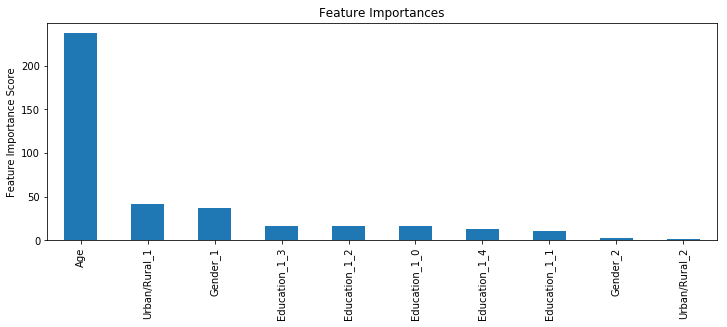

In [24]:
plt.rcParams['figure.figsize'] = 12, 4
target = 'Hyperglycaemia'
predictors = [x for x in X_data_train.columns if x not in [target]]

xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=84)
modelfit(xgb1, X_data_train, X_data_test, predictors)

## Grid seach on n_estimators: Initial step

In [25]:
param_test0 = {
    'n_estimators':range(10,1000,200),
}
gsearch0 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch0.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(10, 1000, 200)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [26]:
#gsearch0.cv_results_,gsearch0.best_params_, gsearch0.best_score_
print("#"*100)
print(gsearch0.best_params_)
print(gsearch0.best_score_)
print("#"*100)

####################################################################################################
{'n_estimators': 10}
0.5928531173521755
####################################################################################################


In [27]:
param_test0a = {
    'n_estimators':range(2,10,2),
}
gsearch0a = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test0a, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch0a.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(2, 10, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [28]:
#gsearch0a.cv_results_,gsearch0a.best_params_, gsearch0a.best_score_
print("#"*100)
print(gsearch0a.best_params_)
print(gsearch0a.best_score_)
print("#"*100)

####################################################################################################
{'n_estimators': 8}
0.5926034438148621
####################################################################################################


## Grid seach on max_depth and min_child_weight: Initial step

In [29]:
param_test1 = {
    'max_depth':range(3,10,1),
    'min_child_weight':range(1,10,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=8, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=8,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(3, 10), 'min_child_weight': range(1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [30]:
#gsearch1.cv_results_,gsearch1.best_params_, gsearch1.best_score_
print("#"*100)
print(gsearch1.best_params_)
print(gsearch1.best_score_)
print("#"*100)

####################################################################################################
{'max_depth': 8, 'min_child_weight': 8}
0.5953274371597013
####################################################################################################


## Grid seach on max_depth and min_child_weight: Step 2

In [31]:
param_test2 = {
    'max_depth':[6,7,8,9,10],
    'min_child_weight':[6,7,8,9,10]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=8, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch2.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=8,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': [6, 7, 8, 9, 10], 'min_child_weight': [6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [32]:
#gsearch2.cv_results_,gsearch2.best_params_, gsearch2.best_score_
print(gsearch2.best_params_)
print(gsearch2.best_score_)
print("#"*100)

{'max_depth': 8, 'min_child_weight': 8}
0.5953274371597013
####################################################################################################


## Grid seach on gamma: Initial step

In [33]:
[0,1,5] + [i/10.0 for i in range(0,5)]

[0, 1, 5, 0.0, 0.1, 0.2, 0.3, 0.4]

In [34]:
#Choose all predictors except target & IDcols
param_test3 = {
    'gamma':[0,1,5] + [i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=8, max_depth=8,
                                        min_child_weight=8, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch3.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=8, missing=None, n_estimators=8,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0, 1, 5, 0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [35]:
# gsearch3.cv_results_,gsearch3.best_params_, gsearch3.best_score_
print("#"*100)
print(gsearch3.best_params_)
print(gsearch3.best_score_)
print("#"*100)


####################################################################################################
{'gamma': 0.1}
0.5959938447815762
####################################################################################################


In [38]:
#Choose all predictors except target & IDcols
param_test4 = {
    'gamma':[0.25,0.5,0.075,0.1,0.125,0.15,0.175]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=8, max_depth=8,
                                        min_child_weight=8, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch4.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=8, missing=None,
       n_estimators=8, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=84, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0.25, 0.5, 0.075, 0.1, 0.125, 0.15, 0.175]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [39]:
# gsearch4.cv_results_,gsearch4.best_params_, gsearch4.best_score_
print("#"*100)
print(gsearch4.best_params_)
print(gsearch4.best_score_)
print("#"*100)

####################################################################################################
{'gamma': 0.1}
0.5959938447815762
####################################################################################################


# Evaluate importance and accuracy


Model Report
Accuracy: 0.7546342153671997
ROC AUC score (Train): 0.6502588132504035
Accuracy (Test): 0.7636167086239072
ROC AUC score (Test): 0.5002660963969929
gbtree


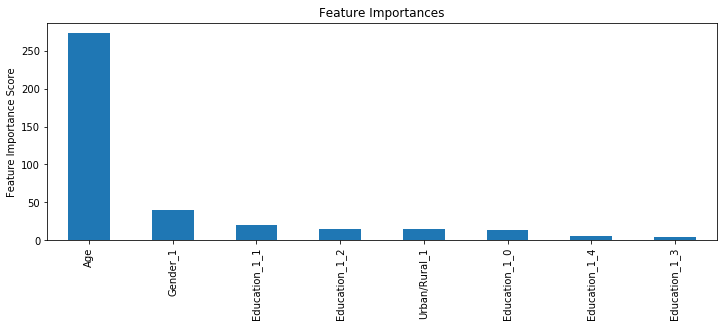

In [40]:
predictors = [x for x in X_data_train.columns if x not in [target]]
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=8,
        max_depth=8,
        min_child_weight=8,
        gamma=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=84)
modelfit(xgb2, X_data_train, X_data_test, predictors)

## Grid seach on subsample and colsample_bytree: Initial step

In [45]:
#Choose all predictors except target & IDcols
param_test5 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=8, max_depth=8,
                                        min_child_weight=8, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch5.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=8, missing=None,
       n_estimators=8, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=84, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [46]:
#gsearch5.cv_results_,gsearch5.best_params_, gsearch5.best_score_
print("#"*100)
print(gsearch5.best_params_)
print(gsearch5.best_score_)
print("#"*100)

####################################################################################################
{'colsample_bytree': 0.8, 'subsample': 0.8}
0.5959938447815762
####################################################################################################


## Grid seach on subsample and colsample_bytree:  Fine-tune

In [47]:
#Choose all predictors except target & IDcols
param_test6 = {
    'subsample':[i/100.0 for i in range(70,100,2)],
    'colsample_bytree':[i/100.0 for i in range(70,100,2)]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=8, max_depth=8,
                                        min_child_weight=8, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=10)

gsearch6.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=8, missing=None,
       n_estimators=8, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=84, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98], 'colsample_bytree': [0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [48]:
#gsearch6.cv_results_,gsearch6.best_params_, gsearch6.best_score_
print("#"*100)
print(gsearch6.best_params_)
print(gsearch6.best_score_)
print("#"*100)

####################################################################################################
{'colsample_bytree': 0.7, 'subsample': 0.76}
0.5962756089708076
####################################################################################################


## Grid seach on reg_alpha: Initial step

In [59]:
#Choose all predictors except target & IDcols
param_test7 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=8, max_depth=8,
                                        min_child_weight=8, gamma=0.1, subsample=0.7, colsample_bytree=0.76,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch7.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.76, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=8, missing=None,
       n_estimators=8, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=84, silent=True, subsample=0.7),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [60]:
#gsearch7.cv_results_,gsearch7.best_params_, gsearch7.best_score_
print("#"*100)
print(gsearch7.best_params_)
print(gsearch7.best_score_)
print("#"*100)

####################################################################################################
{'reg_alpha': 0.01}
0.5958117739447063
####################################################################################################


## Grid seach on reg_alpha: Fine-tune

In [61]:
#Choose all predictors except target & IDcols
param_test8 = {
    'reg_alpha':[0.00005, 0.0001, 0.0005 , 0.001, 0.005, 0.01, 0.025, 0.05, 0.075]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=8, max_depth=8,
                                        min_child_weight=8, gamma=0.1, subsample=0.7, colsample_bytree=0.76,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch8.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.76, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=8, missing=None,
       n_estimators=8, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=84, silent=True, subsample=0.7),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.025, 0.05, 0.075]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [62]:
# gsearch8.cv_results_,gsearch8.best_params_, gsearch8.best_score_
print("#"*100)
print(gsearch8.best_params_)
print(gsearch8.best_score_)
print("#"*100)

####################################################################################################
{'reg_alpha': 0.001}
0.5959275778333752
####################################################################################################


In [63]:
#Choose all predictors except target & IDcols
param_test8a = {
    'reg_alpha':[0.0005, 0.0006, 0.0007, 0.0008, 0.0009 , 0.001, 0.002, 0.003, 0.004, 0.005]
}
gsearch8a = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=8, max_depth=8,
                                        min_child_weight=8, gamma=0.1, subsample=0.7, colsample_bytree=0.76,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test8a, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch8a.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.76, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=8, missing=None,
       n_estimators=8, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=84, silent=True, subsample=0.7),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.002, 0.003, 0.004, 0.005]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [64]:
# gsearch8.cv_results_,gsearch8.best_params_, gsearch8.best_score_
print("#"*100)
print(gsearch8a.best_params_)
print(gsearch8a.best_score_)
print("#"*100)

####################################################################################################
{'reg_alpha': 0.002}
0.5959297138324353
####################################################################################################


## Grid seach on learning_rate: Fine-tune

In [65]:
#Choose all predictors except target & IDcols
param_test9 = {
    'learning_rate':[0.01, 0.025, 0.05, 0.075, 0.1]
}
gsearch9 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=8, max_depth=8,
                                        min_child_weight=8, gamma=0.1, subsample=0.7, colsample_bytree=0.76,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test9, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch9.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.76, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=8, missing=None,
       n_estimators=8, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=84, silent=True, subsample=0.7),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [66]:
# gsearch9.cv_results_,gsearch9.best_params_, gsearch9.best_score_
print("#"*100)
print(gsearch9.best_params_)
print(gsearch9.best_score_)
print("#"*100)

####################################################################################################
{'learning_rate': 0.1}
0.5951479301726466
####################################################################################################



Model Report
Accuracy: 0.7547757181265035
ROC AUC score (Train): 0.6451137523746557
Accuracy (Test): 0.7622931382764664
ROC AUC score (Test): 0.5001521683300244
gbtree


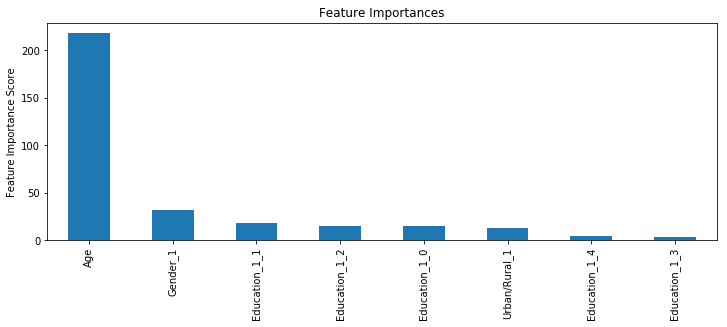

In [67]:
xgb3 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=8,
        max_depth=8,
        min_child_weight=8,
        gamma=0.1,
        subsample=0.7,
        colsample_bytree=0.76,
        reg_alpha=0.002,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=84)
modelfit(xgb3, X_data_train, X_data_test, predictors)

In [68]:
eer_threshold(xgb3, test_X=X_test, test_y=y_test)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:197: RuntimeWarning: invalid value encountered in long_scalars


,EER
0.39,0.006448
0.38,0.070955
0.4,0.080997
0.41,0.131557
0.37,0.139341
0.42,0.205806
0.36,0.277959
0.43,0.296401
0.44,0.315129
0.45,0.369678


(0.39, 0.006447956543125355)

0.0327945803308637


0.05970202452238381

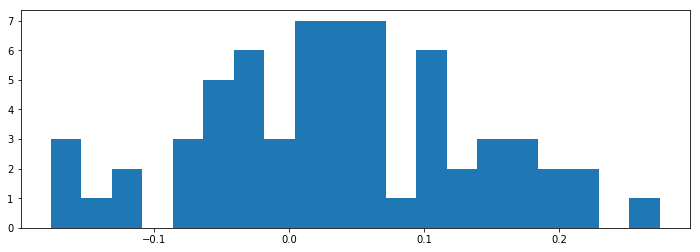

In [69]:
y_predicted = xgb3.predict_proba(X)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.39, 1, 0)
eval_prevalence = pd.DataFrame.from_dict({'actual': y, 'predicted': y_predicted, 'district':ncd_data.loc[y.index,'shdistrict']})
eval_prevalence = eval_prevalence.groupby('district').sum()/eval_prevalence.groupby('district').count()
plt.hist(eval_prevalence['actual'] - eval_prevalence['predicted'], bins=20)
print((eval_prevalence['actual'] - eval_prevalence['predicted']).median())
eval_prevalence['difference'] = np.absolute(eval_prevalence['actual'] - eval_prevalence['predicted'])
eval_prevalence['difference'].median()

0.027624309392265206


0.039954202738353255

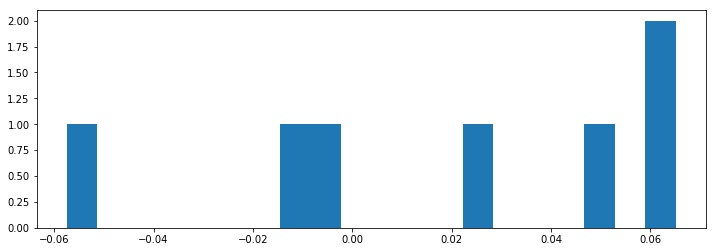

In [70]:
y_predicted = xgb3.predict_proba(X)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.39, 1, 0)
eval_prevalence = pd.DataFrame.from_dict({'actual': y, 'predicted': y_predicted, 'district':ncd_data.loc[y.index,'hv024']})
eval_prevalence = eval_prevalence.groupby('district').sum()/eval_prevalence.groupby('district').count()
plt.hist(eval_prevalence['actual'] - eval_prevalence['predicted'], bins=20)
print((eval_prevalence['actual'] - eval_prevalence['predicted']).median())
eval_prevalence['difference'] = np.absolute(eval_prevalence['actual'] - eval_prevalence['predicted'])
eval_prevalence['difference'].mean()

In [71]:
y_predicted = xgb3.predict_proba(X_test)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.39, 1, 0)
cm1= pd_ml.ConfusionMatrix(y_pred=y_predicted, y_true=y_test,)
cm2 = confusion_matrix(y_pred=y_predicted, y_true=y_test,)
print(cm1)

Predicted  False  True  __all__
Actual                         
False         21     9       30
True           5     3        8
__all__       26    12       38


In [72]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1339
           1       0.31      0.31      0.31       428

   micro avg       0.66      0.66      0.66      1767
   macro avg       0.54      0.54      0.54      1767
weighted avg       0.66      0.66      0.66      1767



#################################################################################################################
#################################################################################################################
#################################################################################################################